In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt

In [193]:
# Import the directory of csv file
data = pd.read_csv(
    r"C:\Users\jhcwgtang\Downloads\07.hk_eui_features_adding_bld_facility_complete_0601_v4.csv",
    index_col=0, encoding='utf-8')

In [194]:
data = data[(data.highrise > 0) | (data.podium > 0)]

In [195]:
# Building Height
data['Area'] = np.where(data['highrise'] == 1, data['area_upper'], data['area_podium'])

In [196]:
# Building Retrofitting due to Energy Audit Policy (Before and After)
data['retro_before'] = np.where(data['retro'] == 'retro_before', 1, 0)  # np.where(condition, x, y)
data['retro_after'] = np.where(data['retro'] == 'retro_after', 1, 0)  # np.where(condition, x, y)

In [197]:
# Year of Building Construction
data.loc[data['Year'] < 1950, 'Year_built_class'] = 1
data.loc[(data['Year'] >= 1950) & (data['Year'] < 1960), 'Year_built_class'] = 2
data.loc[(data['Year'] >= 1960) & (data['Year'] < 1970), 'Year_built_class'] = 3
data.loc[(data['Year'] >= 1970) & (data['Year'] < 1980), 'Year_built_class'] = 4
data.loc[(data['Year'] >= 1980) & (data['Year'] < 1990), 'Year_built_class'] = 5
data.loc[(data['Year'] >= 1990) & (data['Year'] < 2000), 'Year_built_class'] = 6
data.loc[(data['Year'] >= 2000) & (data['Year'] < 2010), 'Year_built_class'] = 7
data.loc[data['Year'] >= 2010, 'Year_built_class'] = 8

In [198]:
# Log10 transformation of Building Footprint
data['log_area'] = np.log10(data['Area'] + 1)  # building footprint 

In [199]:
# Log10 transformation of Kernel Density
data['log_hotel'] = np.log10(data['hotel'] + 1)
data['log_retail'] = np.log10(data['retail'] + 1)
data['log_parking'] = np.log10(data['parking'] + 1)
data['log_food'] = np.log10(data['food'] + 1)
data['log_office'] = np.log10(data['office'] + 1)

In [200]:
# Distance to MTR Transit Station
data['log_mtr_dist'] = np.log10(data['Dist_mtr'])  # the distance between commercial building and MTR
# Only COMMERCIAL land use is considered (11)
data['commercial'] = np.where(data['landuse'] == 11, 1, 0)

In [201]:
# Air condition System  # Haven't mentioned in paper (individual and central)
data['individual_ac'] = np.where(data['AC_type'] == 'Individual Air-Conditioning System', 1, 0)  
data['central_ac'] = np.where(data['AC_type'] == 'Central Air-Conditioning System', 1, 0)

In [202]:
# Number of Lift in a certain building
data['no_lifts'] = data['Passage_lift'] + data['Service_lift']  # Number of Lift = Passenger + Service
no_lifts_percentile = np.nanpercentile(data['no_lifts'], [50, 75])  # 50-75% Lifts
data['no_lifts_c'] = np.where(data['no_lifts'] < no_lifts_percentile[0], "no_lifts_50%below",
                              (np.where(data['no_lifts'] < no_lifts_percentile[1], "no_lifts_50%_75%",
                                        np.where(pd.isna(data['no_lifts']), np.NaN, "no_lifts_75%above"))))  # no value--> 75%

In [203]:
# <50%, 50% to 75%, >75%
data['no_lifts_50%below'] = np.where(data['no_lifts_c'] == 'no_lifts_50%below', 1, 0)
data['no_lifts_50%_75%'] = np.where(data['no_lifts_c'] == 'no_lifts_50%_75%', 1, 0)
data['no_lifts_75%above'] = np.where(data['no_lifts_c'] == 'no_lifts_75%above', 1, 0)

In [204]:
# Building Operation Time
data['Operate_start_before8'] = np.where(data['Operate_start_work'] < 8, 1, 0)
data['Operate_start_8_9'] = np.where(((data['Operate_start_work'] >= 8) & (data['Operate_start_work'] < 9)), 1, 0)
data['Operate_start_9_10'] = np.where(((data['Operate_start_work'] >= 9) & (data['Operate_start_work'] < 10)), 1, 0)
data['Operate_start_after10'] = np.where(data['Operate_start_work'] >= 10, 1, 0)

In [205]:
Operate_hours_percentile = np.nanpercentile(data['Operate_hours'], [25, 50, 75])
data['Operate_hours_c'] = np.where(data['Operate_hours'] < Operate_hours_percentile[0], 'Operate_hours_25%', # <25%
                                   (np.where(data['Operate_hours'] < Operate_hours_percentile[1], 'Operate_hours_50%',  # <50%
                                             (np.where(data['Operate_hours'] < Operate_hours_percentile[2], 'Operate_hours_75%',  # <75%
                                                       (np.where(pd.isna(data['Operate_hours']), np.NaN, 'Operate_hours_100%')))))))  # detect missing data

In [206]:
data['Operate_hours_25%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_25%', 1, 0)
data['Operate_hours_50%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_50%', 1, 0)
data['Operate_hours_75%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_75%', 1, 0)
data['Operate_hours_100%'] = np.where(data['Operate_hours_c'] == 'Operate_hours_100%', 1, 0)

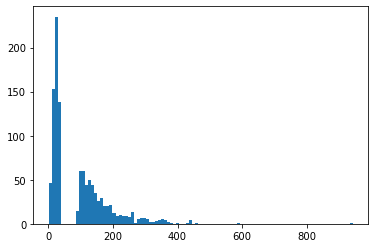

In [207]:
# Building Energy Usage Intensity
y1 = data['bld_eui2']
plt.hist((y1), bins = 100)
plt.show()

In [208]:
# Building Energy Usage Intensity
log_eui = np.log10(data['bld_eui2'])
log_eui_median = log_eui.median()  # Compute the Median of Building EUI

In [209]:
# If a building is below the median,it means it is low EUI. Otherwise, it is considered as high EUI
data['bld_eui2_label'] = np.where(np.log10(data['bld_eui2']) < log_eui_median, "low", "high")

In [210]:
y = data['bld_eui2_label'].reset_index(drop=True)

In [211]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['low','high'])
ylabel = le.transform(y)

In [212]:
from sklearn.preprocessing import KBinsDiscretizer
from matplotlib import pyplot

In [213]:
data_try = np.log10(data['bld_eui2'])

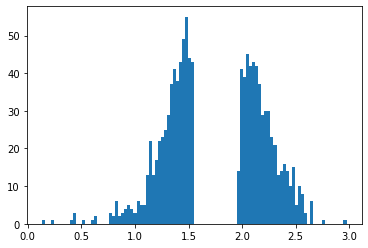

In [214]:
y1 = data['bld_eui2']
plt.hist(np.log10(y1), bins = 100)
plt.show()

In [215]:
# X1+X2+X3+X4........+Xn
X = data[['log_area', 'Storey',
          'Year_built_class',
          'log_hotel', 'log_parking', 'log_food', 'log_office', 'log_retail',
          'td_cdd',
          'wind10m',
          'ghi',
          'retro_before', 'retro_after',
          'log_mtr_dist',
          'commercial',
          'individual_ac',
          'central_ac',
          'no_lifts_50%below', 'no_lifts_50%_75%', 'no_lifts_75%above',
          'Operate_start_before8', 'Operate_start_8_9', 'Operate_start_9_10', 'Operate_start_after10',
          'Operate_hours_25%', 'Operate_hours_50%', 'Operate_hours_75%', 'Operate_hours_100%',
          #'ndbi',
          #'ndvi'
          ]].reset_index(drop=True)

In [216]:
X

,log_area,Storey,Year_built_class,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,...,no_lifts_50%_75%,no_lifts_75%above,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,Operate_hours_25%,Operate_hours_50%,Operate_hours_75%,Operate_hours_100%
0,1.903090,27,6.0,0.000000,0.000000,2.638749,2.957643,2.483435,2.50708,3.97374,...,0,0,0,0,0,0,0,0,0,0
1,2.747412,24,5.0,0.000000,1.835583,2.729186,3.087895,3.092594,2.47126,2.48644,...,1,0,0,1,0,0,0,1,0,0
2,2.471292,22,6.0,0.000000,0.000000,3.432713,2.093243,2.958709,2.47126,2.91427,...,1,0,0,1,0,0,1,0,0,0
3,2.424882,24,7.0,1.900766,1.980961,2.589470,2.187803,2.612417,2.50708,3.98256,...,0,0,0,0,0,0,0,0,0,0
4,1.724276,5,4.0,1.969084,1.920434,2.918812,0.000000,2.858100,2.50708,3.10741,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,4.336680,3,6.0,0.000000,1.971251,2.874415,2.314497,3.254323,2.36382,2.55012,...,0,0,0,0,0,0,0,0,0,0
1120,3.935054,2,5.0,0.000000,1.932683,3.284462,2.932106,3.444855,2.54289,2.20029,...,0,0,0,0,0,0,0,0,0,0
1121,3.574610,2,6.0,0.000000,2.004215,2.343308,0.000000,2.697563,2.36382,2.57027,...,0,0,0,0,0,0,0,0,0,0
1122,4.135292,2,6.0,0.000000,0.000000,1.961505,0.000000,2.858893,2.43545,2.41758,...,0,0,0,0,0,0,0,0,0,0


In [217]:
y

0        low
1       high
2       high
3        low
4        low
        ... 
1119    high
1120    high
1121    high
1122    high
1123     low
Name: bld_eui2_label, Length: 1124, dtype: object

In [218]:
# X1+X2+X3+X4........+Xn
Dataset = data[['bld_eui2_label','log_area', 'Storey',
          'Year_built_class',
          'log_hotel', 'log_parking', 'log_food', 'log_office', 'log_retail',
          'td_cdd',
          'wind10m',
          'ghi',
          'retro_before', 'retro_after',
          'log_mtr_dist',
          'commercial',
          'individual_ac',
          'central_ac',
          'no_lifts_50%below', 'no_lifts_50%_75%', 'no_lifts_75%above',
          'Operate_start_before8', 'Operate_start_8_9', 'Operate_start_9_10', 'Operate_start_after10',
          'Operate_hours_25%', 'Operate_hours_50%', 'Operate_hours_75%', 'Operate_hours_100%',
          'ndbi',
          'ndvi'
          ]].reset_index(drop=True)
Dataset.to_csv('ALL_Dataset.csv',index=False)

In [219]:
# Random Forest
seed = 8000
rf = RandomForestClassifier(random_state=seed)

n_estimators = [int(x) for x in np.linspace(start=10, stop=500, num=50)]
max_features = ['auto', 'sqrt', 'log2']  # 默认值为"auto"
max_depth = [int(x) for x in np.linspace(3, 10, num=20)]
max_depth.append(None)
min_samples_split = [8, 10, 12, 14, 16, 18, 20, 30]
min_samples_leaf = [4, 6, 8]
bootstrap = [True, False]
criterion = ['gini', 'entropy']  # 可选择(默认值为“gini”)

parameter_dis = {'n_estimators': n_estimators,  # number of trees in the forest
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap,
                 'criterion': criterion}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=parameter_dis,
                               n_iter=200, cv=5, verbose=1, n_jobs=-1, scoring='accuracy', refit=False)
rf_random.fit(X, y)

# Selecting the best parameter
best_params_ = rf_random.best_params_

# Random Forest Classification
rf = RandomForestClassifier(random_state=seed,
                            n_estimators=best_params_['n_estimators'],
                            min_samples_split=best_params_['min_samples_split'],
                            min_samples_leaf=best_params_['min_samples_leaf'],
                            max_features=best_params_['max_features'],
                            max_depth=best_params_['max_depth'],
                            bootstrap=best_params_['bootstrap'],
                            criterion=best_params_['criterion'])

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    y_pred = rf.predict(X.iloc[test])
    print(metrics.classification_report(y.iloc[test], y_pred, digits=4))
    print("--------------------------------- Random Forest Result ----------------------------------------")
    print(rf.score(X.iloc[test], y.iloc[test]))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
              precision    recall  f1-score   support

        high     0.8571    0.7241    0.7850       116
         low     0.7480    0.8716    0.8051       109

    accuracy                         0.7956       225
   macro avg     0.8026    0.7978    0.7951       225
weighted avg     0.8043    0.7956    0.7948       225

--------------------------------- Random Forest Result ----------------------------------------
0.7955555555555556
              precision    recall  f1-score   support

        high     0.8218    0.7094    0.7615       117
         low     0.7258    0.8333    0.7759       108

    accuracy                         0.7689       225
   macro avg     0.7738    0.7714    0.7687       225
weighted avg     0.7757    0.7689    0.7684       225

--------------------------------- Random Forest Result ----------------------------------------
0.7688888888888888
              precision    recall  f1-score   suppor

In [220]:
# XGBoost
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

data_matrix = xgb.DMatrix(data=X, label=ylabel)

space = {'max_depth': hp.quniform("max_depth", 3, 10, 1),
         'learning_rate': hp.uniform("learning_rate", 0.05, 0.3),
         'colsample_bytree': hp.uniform("colsample_bytree", 0.5, 1),
         'min_child_weight': hp.quniform("min_child_weight", 1, 20, 1),
         'reg_alpha': hp.quniform("reg_alpha", 0, 100, 1),
         'reg_lambda': hp.uniform("reg_lambda", 0, 2),
         'subsample': hp.uniform("subsample", 0.5, 1),
         'min_split_loss': hp.uniform("min_split_loss", 0, 9),
         'rate_drop': hp.uniform("rate_drop", 0, 1)}


def fobjective(space):
    param_dict_tunning = {'max_depth': int(space['max_depth']),
                          'learning_rate': space['learning_rate'],
                          'colsample_bytree': space['colsample_bytree'],
                          'min_child_weight': int(space['min_child_weight']),
                          'reg_alpha': int(space['reg_alpha']),
                          'reg_lambda': space['reg_lambda'],
                          'subsample': space['subsample'],
                          'min_split_loss': space['min_split_loss'],
                          'booster': 'gbtree',
                          # 'rate_drop': space['rate_drop'],
                          'objective': 'binary:logistic'}
    xgb_cv_result = xgb.cv(dtrain=data_matrix, params=param_dict_tunning, nfold=5, early_stopping_rounds=30,
                           as_pandas=True, num_boost_round=200, seed=8000, metrics='error')

    return {"loss": (xgb_cv_result["test-error-mean"]).tail(1).iloc[0], "status": STATUS_OK}


trials = Trials()
best_hyperparams = fmin(fn=fobjective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

param_dict_tunning = {'objective': 'binary:logistic', 'eval_metric': 'error',
                      'max_depth': int(best_hyperparams['max_depth']),
                      'reg_alpha': best_hyperparams['reg_alpha'], 'reg_lambda': best_hyperparams['reg_lambda'],
                      'min_child_weight': best_hyperparams['min_child_weight'],
                      'colsample_bytree': best_hyperparams['colsample_bytree'],
                      'learning_rate': best_hyperparams['learning_rate'], 'subsample': best_hyperparams['subsample'],
                      'min_split_loss': best_hyperparams['min_split_loss'],
                      # 'rate_drop':best_hyperparams['rate_drop'],
                      'booster': 'gbtree'}

# xgb_cv_result = xgb.cv(dtrain=data_matrix, params=param_dict_tunning, nfold=5, early_stopping_rounds=30,
#                       as_pandas=True, num_boost_round = 200, seed=8000, metrics='error')

for train, test in KFold(n_splits=5, shuffle=True, random_state=8000).split(X, ylabel):
    input_matrix = xgb.DMatrix(data=X.loc[train], label=ylabel[train])
    test_matrix = xgb.DMatrix(data=X.loc[test], label=ylabel[test])
    watchlist = [(test_matrix, 'eval'), (input_matrix, 'train')]

    xgb_model = xgb.train(params=param_dict_tunning, dtrain=input_matrix, num_boost_round=200, evals=watchlist,
                          xgb_model=None, verbose_eval=False, early_stopping_rounds=30)

    y_pred_pro = xgb_model.predict(test_matrix)
    y_pred = [round(value) for value in y_pred_pro]
    y_true = ylabel[test]
    print("----------------------------------------- XGBoost Result -------------------------------------------------")
    print(metrics.classification_report(y_true, y_pred, digits=4))

  0%|                                                                          | 0/200 [00:00<?, ?trial/s, best loss=?]

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


100%|███████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.92trial/s, best loss: 0.1788054]


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8614    0.7500    0.8018       116
           1     0.7661    0.8716    0.8155       109

    accuracy                         0.8089       225
   macro avg     0.8138    0.8108    0.8086       225
weighted avg     0.8152    0.8089    0.8084       225

----------------------------------------- XGBoost Result -------------------------------------------------


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


              precision    recall  f1-score   support

           0     0.8200    0.7009    0.7558       117
           1     0.7200    0.8333    0.7725       108

    accuracy                         0.7644       225
   macro avg     0.7700    0.7671    0.7641       225
weighted avg     0.7720    0.7644    0.7638       225

----------------------------------------- XGBoost Result -------------------------------------------------


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


              precision    recall  f1-score   support

           0     0.7900    0.7524    0.7707       105
           1     0.7920    0.8250    0.8082       120

    accuracy                         0.7911       225
   macro avg     0.7910    0.7887    0.7894       225
weighted avg     0.7911    0.7911    0.7907       225



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.7983    0.8559    0.8261       111
           1     0.8491    0.7895    0.8182       114

    accuracy                         0.8222       225
   macro avg     0.8237    0.8227    0.8221       225
weighted avg     0.8240    0.8222    0.8221       225

----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8257    0.7895    0.8072       114
           1     0.7913    0.8273    0.8089       110

    accuracy                         0.8080       224
   macro avg     0.8085    0.8084    0.8080       224
weighted avg     0.8088    0.8080    0.8080       224



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [236]:
# Deep learning
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

model = Sequential()
model.add(Dense(24, input_dim=len(X.iloc[0]), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X_normalized, ylabel), range(5)):
    model.fit(X_normalized[train], ylabel[train], epochs=150, batch_size=1024, verbose=0)

    y_pred_pro = model.predict(X_normalized[test], batch_size=1024, verbose=0)
    y_pred = np.round(y_pred_pro)
    print("----------------------------------- Deep Learning Result -------------------------------------------------")
    print(metrics.classification_report(ylabel[test], y_pred, digits=4))

    # accuracy = model.evaluate(X_normalized[test], ylabel[test],batch_size=1024,verbose=0)
    # print('Accuracy: %.2f' % (accuracy*100))

----------------------------------- Deep Learning Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8542    0.7069    0.7736       116
           1     0.7364    0.8716    0.7983       109

    accuracy                         0.7867       225
   macro avg     0.7953    0.7892    0.7860       225
weighted avg     0.7971    0.7867    0.7856       225

----------------------------------- Deep Learning Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8265    0.6923    0.7535       117
           1     0.7165    0.8426    0.7745       108

    accuracy                         0.7644       225
   macro avg     0.7715    0.7675    0.7640       225
weighted avg     0.7737    0.7644    0.7636       225

----------------------------------- Deep Learning Result -------------------------------------------------
              precision  

In [222]:
# Support vector machine

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

param_SVC = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}

SVC_grid = GridSearchCV(SVC(), param_SVC, refit=False, verbose=0, cv=5, scoring='accuracy')
SVC_grid.fit(X_normalized, ylabel)

SVC_model = SVC(**SVC_grid.best_params_)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X_normalized, ylabel), range(5)):
    SVC_model.fit(X_normalized[train], y[train])

    y_pred = SVC_model.predict(X_normalized[test])
    print("--------------------------------------------- SVM Result -------------------------------------------------")
    print(metrics.classification_report(y[test], y_pred, digits=4))

    print(SVC_model.score(X_normalized[test], y[test]))

--------------------------------------------- SVM Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.9186    0.6810    0.7822       116
         low     0.7338    0.9358    0.8226       109

    accuracy                         0.8044       225
   macro avg     0.8262    0.8084    0.8024       225
weighted avg     0.8291    0.8044    0.8018       225

0.8044444444444444
--------------------------------------------- SVM Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8488    0.6239    0.7192       117
         low     0.6835    0.8796    0.7692       108

    accuracy                         0.7467       225
   macro avg     0.7661    0.7518    0.7442       225
weighted avg     0.7695    0.7467    0.7432       225

0.7466666666666667
--------------------------------------------- SVM Result -------------------------------------

In [223]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}

NB_grid = GridSearchCV(GaussianNB(), param_grid=params_NB, cv=5, verbose=0, scoring='accuracy')
NB_grid.fit(X, ylabel)

NB_model = GaussianNB(**NB_grid.best_params_)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X, ylabel), range(5)):
    NB_model.fit(X.iloc[train], y[train])
    y_pred = NB_model.predict(X.iloc[test])
    print("------------------------------------- Native Bayes Result -------------------------------------------------")
    print(metrics.classification_report(y.iloc[test], y_pred, digits=4))
    print(NB_model.score(X.iloc[test], y[test]))

------------------------------------- Native Bayes Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8889    0.6207    0.7310       116
         low     0.6944    0.9174    0.7905       109

    accuracy                         0.7644       225
   macro avg     0.7917    0.7691    0.7607       225
weighted avg     0.7947    0.7644    0.7598       225

0.7644444444444445
------------------------------------- Native Bayes Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8642    0.5983    0.7071       117
         low     0.6736    0.8981    0.7698       108

    accuracy                         0.7422       225
   macro avg     0.7689    0.7482    0.7385       225
weighted avg     0.7727    0.7422    0.7372       225

0.7422222222222222
------------------------------------- Native Bayes Result ----------------------------------

In [224]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=500)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)

for (train, test), i in zip(cv.split(X, ylabel), range(5)):
    logit.fit(X.iloc[train], ylabel[train])
    y_pred = logit.predict(X.iloc[test])
    print("--------------------------------- Logistic Regression Result ----------------------------------------")
    print(metrics.classification_report(ylabel[test], y_pred, digits=4))
    print("--------------------------------- Logistic Regression Result ----------------------------------------")
    print(logit.score(X.iloc[test], ylabel[test]))

--------------------------------- Logistic Regression Result ----------------------------------------
              precision    recall  f1-score   support

           0     0.8571    0.7759    0.8145       116
           1     0.7833    0.8624    0.8210       109

    accuracy                         0.8178       225
   macro avg     0.8202    0.8191    0.8177       225
weighted avg     0.8214    0.8178    0.8176       225

--------------------------------- Logistic Regression Result ----------------------------------------
0.8177777777777778
--------------------------------- Logistic Regression Result ----------------------------------------
              precision    recall  f1-score   support

           0     0.8211    0.6667    0.7358       117
           1     0.7000    0.8426    0.7647       108

    accuracy                         0.7511       225
   macro avg     0.7605    0.7546    0.7503       225
weighted avg     0.7629    0.7511    0.7497       225

---------------------

 97%|=================== | 2191/2248 [00:34<00:00]       

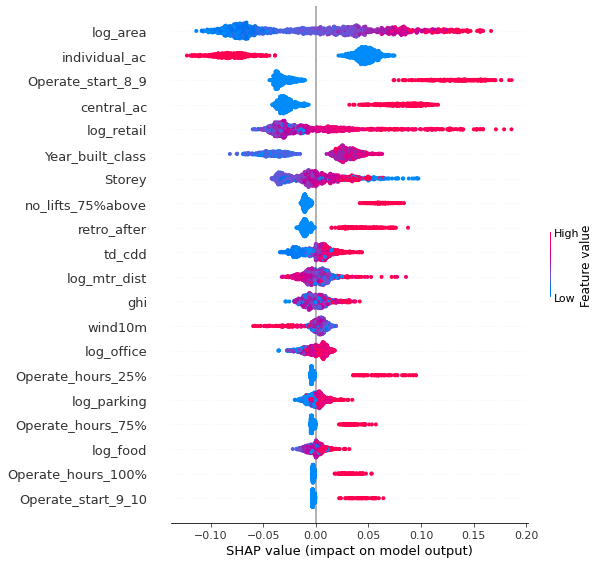

In [225]:
# Shapley Value
import shap

explainer = shap.TreeExplainer(rf, X, model_output='probability')
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values[0], X)

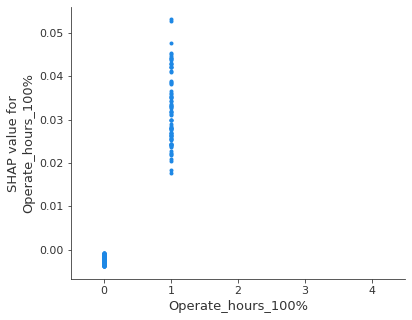

In [226]:
shap.dependence_plot("Operate_hours_100%", shap_values[0], X, xmin=-0.5, xmax=4.5, interaction_index=None, show=False,
                     ax=None)